In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- Lendo arquivo

In [2]:
dados = pd.read_csv('temperature.csv')

- Exibir as 5 priemiras linhas

In [3]:
dados.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


- Infos sobre os dados

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


- Modificando para datetime object, essencial ao trabalhar com time series


In [5]:
dados['Date'] = pd.to_datetime(dados['Date'])

In [6]:
dados = dados.set_index('Date')
dados.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


### Criação de gráfico da série temporal

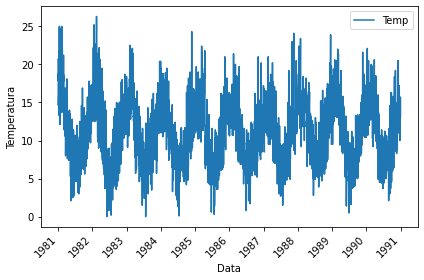

In [7]:
dados.plot()
plt.xticks(rotation=45)
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.tight_layout()

- Decomposição

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
resultado = seasonal_decompose(dados['Temp'], period=12)

- Separando em tendencia, sazonalidade e residuo

In [9]:
tendencia = resultado.trend
sazonalidade = resultado.seasonal
residuo = resultado.resid

- Plot da decomposição

Text(0.5, 1.0, 'Tendência')

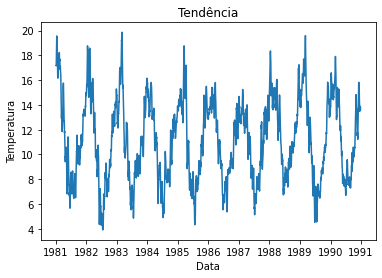

In [10]:
plt.plot(tendencia)
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.title('Tendência')

Text(0.5, 1.0, 'Sazonalidade')

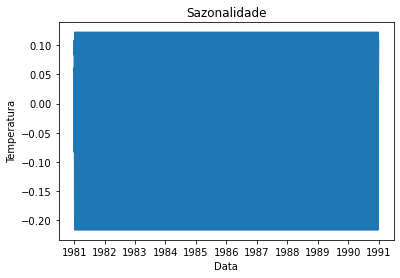

In [11]:
plt.plot(sazonalidade)
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.title('Sazonalidade')

Text(0.5, 1.0, 'Resíduo')

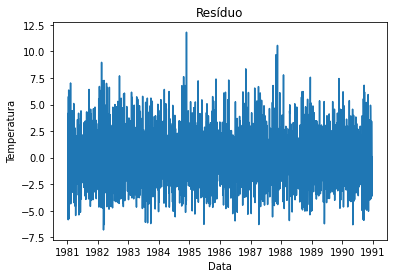

In [12]:
plt.plot(residuo)
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.title('Resíduo')

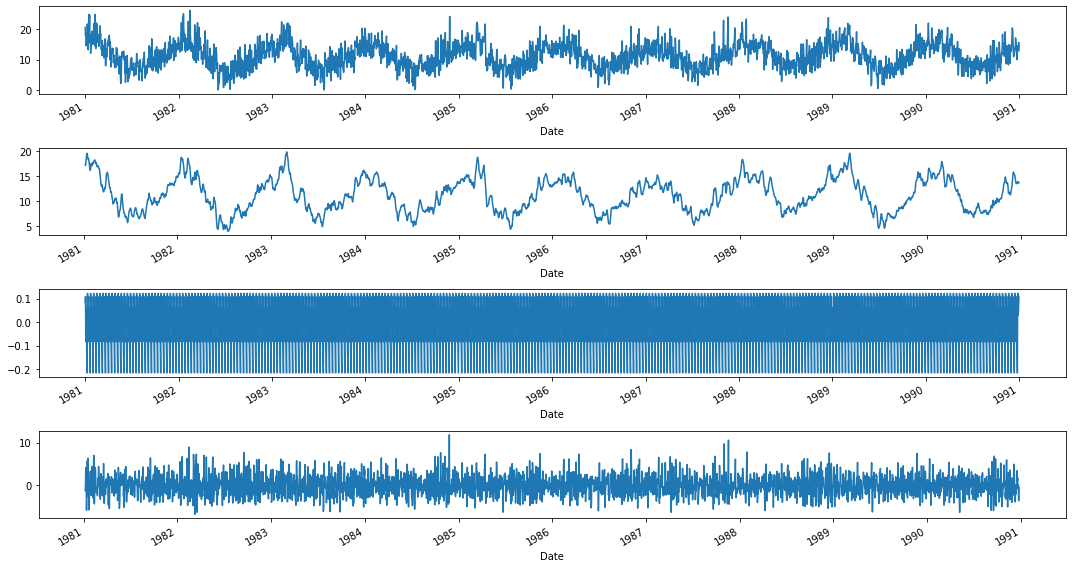

In [13]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
resultado.observed.plot(ax=ax1)
resultado.trend.plot(ax=ax2)
resultado.seasonal.plot(ax=ax3)
resultado.resid.plot(ax=ax4)
plt.tight_layout()

# Teste ADF

- Extração do vetor carateristica para o teste ADF

In [14]:
from statsmodels.tsa.stattools import adfuller
X = dados.values

In [15]:
testeadf = adfuller(X)

In [16]:
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(testeadf[0]))
print('Valor-p: {:.4f}'.format(testeadf[1]))
print('Valores Críticos:')
for key, value in testeadf[4].items():
    print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -4.4448
Valor-p: 0.0002
Valores Críticos:
	1%: -3.4322
	5%: -2.8623
	10%: -2.5672


- Claramente a série é estacionária

# Forecasting com ARIMA

ARIMA significa AutoRegressive Integrated Moving Average e é um dos modelos mais usados para fazer previsões em cima de séries temporais.

O acrônimo significa:

- AR: Autoregression, pois usa a relação de dependência entre uma observação e um número de lagged observations.
- I: Integrated, pois usa a diferenciação das observações crua para transformar a time series em estacionária.
- MA: Moving Average, pois usa a dependência entre uma observação e o erro residual proveniente de uma média móvel aplicada a lagged observations.
Cada um desses componentes são representados por um parâmetro do modelo. Por esse fato, é muito comum ver a notação ARIMA(p,d,q) .

Para encontrar os parâmetros de p, d, e q, usaremos as funções ACF (Autocorrelação) e PACF (Autocorrelação Parcial).

- Autocorrelaçao é um tipo de dependência temporal, é quando uma série está linearmente correlacionada com uma versão dela mesma no passado
- Correlação ocorre quando duas variáveis independentes estão relacionadas linearmente

Analisar ACF e PACF são ações necessárias para aplicar o modelo ARIMA

In [17]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

- Gráfico da autocorrelação

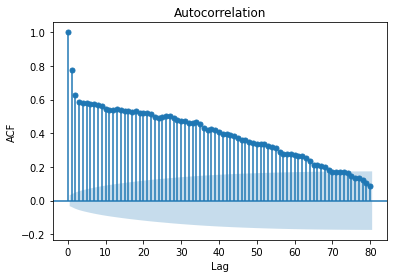

In [18]:
plot_acf(dados.values,lags=80)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

- Range limitado

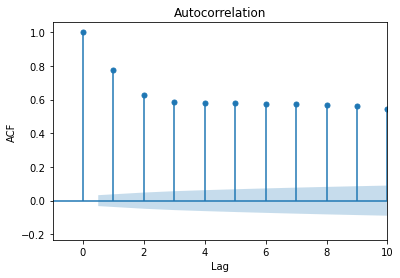

In [19]:
plot_acf(dados.values,lags=80)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.xlim([-1,10])
plt.show()

O ACF tem valor aparente em 2
- Gráfico Autocorrelação parcial

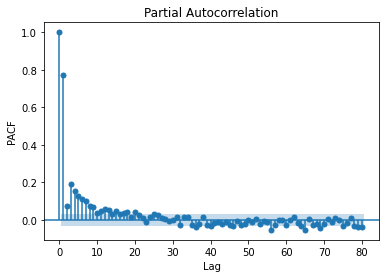

In [20]:
plot_pacf(dados.values,lags=80)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

Alterando o range

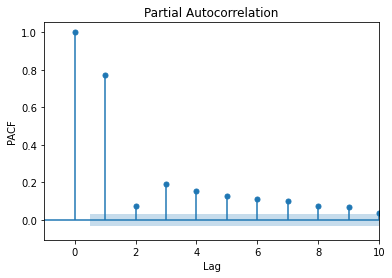

In [21]:
plot_pacf(dados.values,lags=80)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.xlim([-1,10])
plt.show()

- PACF Aparenta ter lag igual a 2

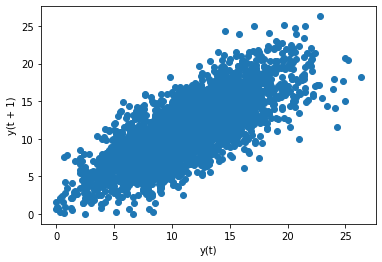

In [22]:
from pandas.plotting import lag_plot

lag_plot(dados);

# Modelo AR(autoregressão)

- Autoregressão significa que é uma regressão da variável contra ela mesma
- Variável de interresse é predita usando uma combinação linear dos valores passados da variável
- Parecido com uma regressão múltipla mas com valores atrasados de y(t) como preditos
- Normalmente restrigimos o modelo AR para dados estacionários

In [23]:
t_treino = dados[dados.index<'1990-01-01'].index.values
t_teste = dados[dados.index>='1990-01-01'].index.values
X_treino = dados[dados.index<'1990-01-01'].values
X_teste = dados[dados.index>='1990-01-01'].values

- Treinando modelo autoregressivo

In [24]:
from statsmodels.tsa.ar_model import AutoReg

In [25]:
modelo = AutoReg(X_treino, 2)
resultado = modelo.fit()
print(resultado.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3285
Model:                     AutoReg(2)   Log Likelihood               -7768.071
Method:               Conditional MLE   S.D. of innovations              2.579
Date:                Tue, 27 Sep 2022   AIC                              1.897
Time:                        19:43:48   BIC                              1.904
Sample:                             2   HQIC                             1.900
                                 3285                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3109      0.137     16.809      0.000       2.041       2.580
y.L1           0.7113      0.017     40.890      0.000       0.677       0.745
y.L2           0.0807      0.017      4.643      0.0

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [26]:
resultado2 = modelo.fit(cov_type="HC0")
print(resultado2.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3285
Model:                     AutoReg(2)   Log Likelihood               -7768.071
Method:               Conditional MLE   S.D. of innovations              2.579
Date:                Tue, 27 Sep 2022   AIC                              1.897
Time:                        19:43:48   BIC                              1.904
Sample:                             2   HQIC                             1.900
                                 3285                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3109      0.137     16.915      0.000       2.043       2.579
y.L1           0.7113      0.020     36.440      0.000       0.673       0.750
y.L2           0.0807      0.018      4.437      0.0

In [27]:
print('Coefficients: %s' % resultado2.params)

Coefficients: [2.3109125  0.71131506 0.08070723]


- Executando predições

In [28]:
X_pred = resultado2.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1, dynamic=False)

- Plotando predição

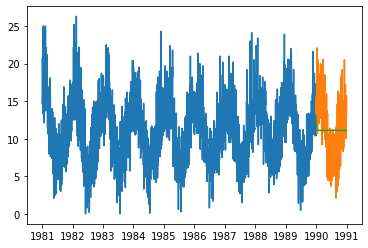

In [29]:
plt.plot(t_treino,X_treino)
plt.plot(t_teste,X_teste)
plt.plot(t_teste,X_pred);

- Calculo do error

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
MSE = mean_squared_error(X_teste,X_pred)
RMSE = np.sqrt(MSE)
print("RMSE = {:0.2f}".format(RMSE))

RMSE = 3.88


# Modelo Média Móvel(MA)

In [32]:
t_treino = dados[dados.index<'1990-01-01'].index
t_teste = dados[dados.index>='1990-01-01'].index
X_treino = dados[dados.index<'1990-01-01']
X_teste = dados[dados.index>='1990-01-01']

In [33]:
forecast = len(X_teste)
y_hat_avg = X_teste.copy()


In [34]:
y_hat_avg['predicao'] = 0

In [35]:
for i in range(forecast):
    y_hat_avg['predicao'].iloc[i] = X_treino['Temp'].rolling(i).mean().iloc[-1]

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [36]:
y_hat_avg = y_hat_avg.dropna()

In [37]:
t_treino = t_treino.values
X_treino = X_treino.values
t_teste = t_teste.values
X_teste = X_teste.values
X_pred = y_hat_avg.values

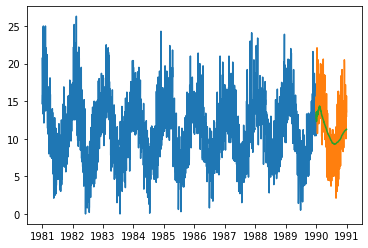

In [38]:
plt.plot(t_treino,X_treino)
plt.plot(t_teste,X_teste)
plt.plot(t_teste[1:],y_hat_avg['predicao'])

In [39]:
MSE = mean_squared_error(X_teste[1:],y_hat_avg['predicao'])
RMSE = np.sqrt(MSE)
print("RMSE = {:0.2f}".format(RMSE))

RMSE = 3.09


# Modelo Auto Regressivo integrado Média Móvel(ARIMA)

In [58]:
t_treino = dados[dados.index<'1990-01-01'].index.values
t_teste = dados[dados.index>='1990-01-01'].index.values
X_treino = dados[dados.index<'1990-01-01'].values
X_teste = dados[dados.index>='1990-01-01'].values

- Aplicando modelo autoregressivo

In [94]:
from statsmodels.tsa.arima.model import ARIMA

In [111]:
modelo = ARIMA(X_treino, order=(2,0,2))
resultado = modelo.fit()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


- Coeficientes

In [112]:
print('Coefficients: %s' % resultado.params)

Coefficients: [11.44583566  1.23870527 -0.24435337 -0.64919355 -0.22667231  5.86310303]


- Fazendo predições

In [113]:
X_pred = resultado.predict(start=len(X_treino), end=len(X_treino)+len(X_teste)-1)

- Calculando erros

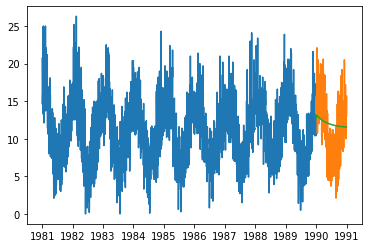

In [114]:
plt.plot(t_treino,X_treino)
plt.plot(t_teste,X_teste)
plt.plot(t_teste,X_pred)

- Calculando erros

In [115]:
MSE = mean_squared_error(X_teste,X_pred)
RMSE = np.sqrt(MSE)
print("RMSE = {:0.2f}".format(RMSE))

RMSE = 3.70
